# Predict the number of passengers on a airplane with LSTM with EarlyStopping

Next we will train an LSTM model to predict the number of airplane passengers. Code based on https://github.com/gianfelton/ and and course https://www.coursera.org/projects/series-temporales-con-deep-learning-rnn-lstm-prophet

**Virtual environment with the following configuration:**
python==3.10.12   h5py==3.9.0    numpy==1.25.2   tensorflow==2.15.0   pandas==2.0.3   statsmodel==0.14.1   matplotlib==3.7.1
sklearn==1.2.2    keras==2.15.0  prophet==1.1.5  seaborn==0.12.2      cmdstanpy==1.2.2

#### Set the TensorFlow logging level to ERROR, which means only error messages will be displayed and warnings will be ignored.

In [2]:
import os
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

### import data

In [6]:
df = pd.read_csv('AirPassengers.csv')

## Data Pre-processing

#### change format to date and index creation

In [7]:
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")

#### seasonal_decompose

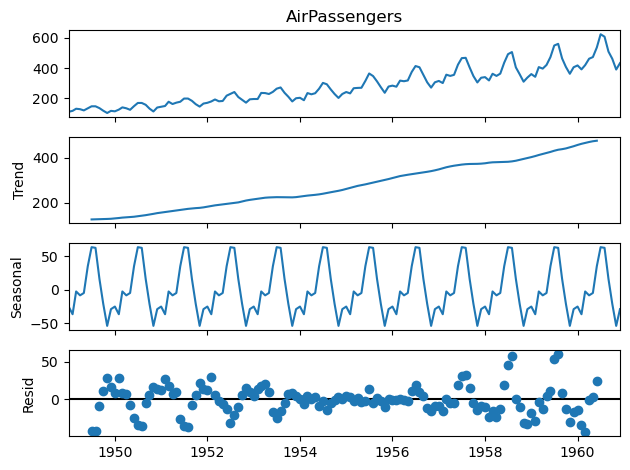

In [8]:
a = seasonal_decompose(df.AirPassengers, model = "add")
a.plot();

#### seasonal_plot

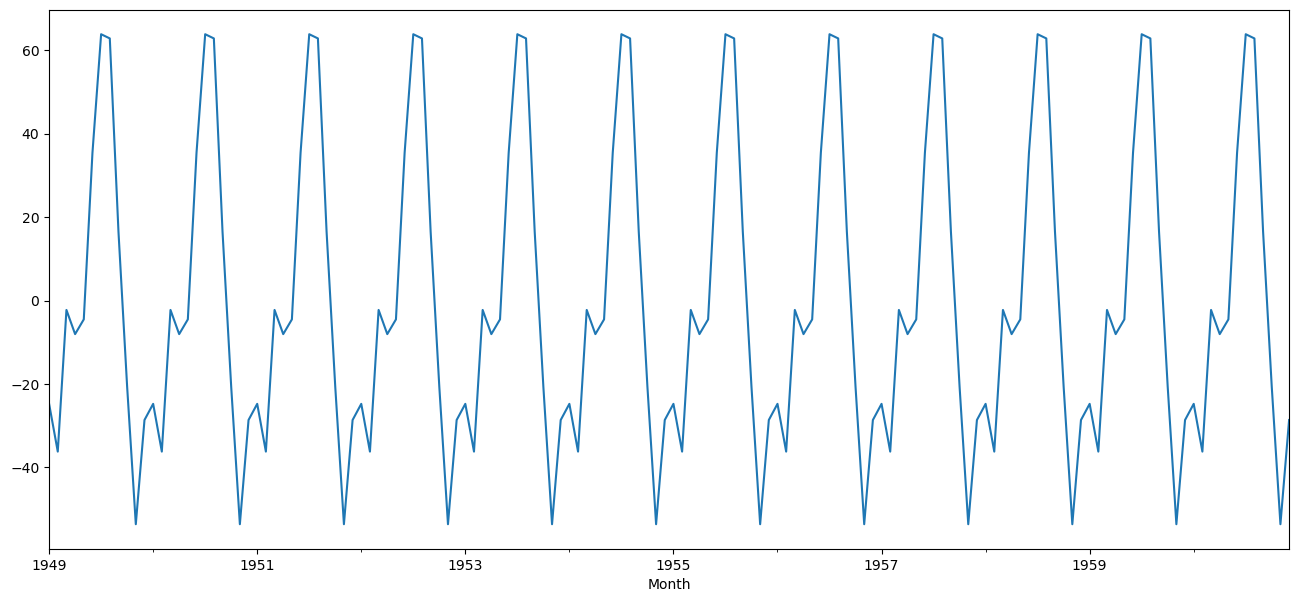

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

### training and testing data set definition

In [10]:
train, test = df[:-12], df[-12:]

In [11]:
##generate an independent copy of the data under train
train_original = train.copy()

#generate an independent copy of the data under test
test_original = test.copy()

### data preprocessing with MinMaxScaler

In [12]:
#definition of the normalization method
scaler = MinMaxScaler()

#scaler learns the parameters from the training data. These parameters are used to transform the data.
scaler.fit(train)

#the training data is scaled (e.g., standardized or normalized) using the parameters learned in the previous step.
train_scaled = scaler.transform(train)

#the test data is scaled (e.g., standardized or normalized) using the parameters learned in the previous step.
test_scaled = scaler.transform(test)

### creation of the Time Series Generator object.

In [13]:
#input is the number of time steps that will be used as input to predict the next time step (12 prediction periods)
n_input = 12

#n_features is the number of features in the input data. In this case, there is only one feature.
n_features = 1

#create the TimeseriesGenerator instance
#The arguments are the input and output data (in this case, both are scaled_train_data)
#TimeseriesGenerator will generate batches of 12 consecutive time slots of scaled_train_data as input and the 
#3th time slot as output.
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=6)

### LSTM model training

In [14]:
#Import libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

#creation of the sequential model.
lstm_model = Sequential()

#adding an LSTM (Long Short-Term Memory) layer. With 100 neurons, ReLU (Rectified Linear Unit) activation function, 
#n_input = 12 prediction periods, n_features = only one feature
lstm_model.add(LSTM(100, activation='relu',return_sequences=True,
                    input_shape=(n_input, n_features)))

#adding an LSTM layer with 100 neuron and return_sequences=True (returns output sequences to add another layer)
lstm_model.add(LSTM(100, return_sequences=True))

#Dropout layer randomly removes some neurons to avoid overfitting
lstm_model.add(Dropout(rate=0.2))

#adding an LSTM layer with 300 neuron and return_sequences=True (returns output sequences to add another layer)
lstm_model.add(LSTM(300, return_sequences=False))

#adding a dense layer to your model (results output)
lstm_model.add(Dense(1))

#ModelCheckpoint, allows you to save the best model of the training process in .h5 format, "val_:loss" metric, 
#save_best_only=True (saves the best model according to "val_:loss")
mc = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', mode='min', 
                     verbose=1, save_best_only=True)

#model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 12, 100)           80400     
                                                                 
 dropout (Dropout)           (None, 12, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 300)               481200    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 602701 (2.30 MB)
Trainable params: 602701 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
#model compilation. Optimizer = adam, loss='mse' (Mean Squared Error)
lstm_model.compile(optimizer='adam', 
              loss='mse')

### EarlyStopping y Validation Generator

In [16]:
#import library
from tensorflow.keras.callbacks import EarlyStopping

# An early_stop object is created using the Keras EarlyStopping class
#The monitor argument specifies which metric should be monitored (in this case, validation loss).
#The patience argument indicates how many epochs to wait without improvements in the metric before stopping training (12 epochs).
early_stop = EarlyStopping(monitor='val_loss',
                           patience=18)

In [17]:
#Time series generator for validation
#A time series generator called validation_generator is created.
#This generator is used to generate test data sequences with length equal to n_input (12 predictions).
validation_generator = TimeseriesGenerator(test_scaled,test_scaled, 
                                           length=n_input-1)

In [18]:
# fit model with EarlyStopping (early_stop), Validation Generator (validation_generator) and ModelCheckpoint (mc)
lstm_model.fit_generator(generator,epochs=40,
                    validation_data=validation_generator,
                   callbacks=[early_stop, mc])

Epoch 1/40
20/20 [==============================] - ETA: 0s - loss: 0.0422
Epoch 1: val_loss improved from inf to 0.04487, saving model to best_model_lstm.h5
20/20 [==============================] - 62s 536ms/step - loss: 0.0422 - val_loss: 0.0449
Epoch 2/40
20/20 [==============================] - ETA: 0s - loss: 0.0139
Epoch 2: val_loss improved from 0.04487 to 0.00524, saving model to best_model_lstm.h5
20/20 [==============================] - 10s 493ms/step - loss: 0.0139 - val_loss: 0.0052
Epoch 3/40
20/20 [==============================] - ETA: 0s - loss: 0.0115
Epoch 3: val_loss improved from 0.00524 to 0.00010, saving model to best_model_lstm.h5
20/20 [==============================] - 8s 372ms/step - loss: 0.0115 - val_loss: 1.0194e-04
Epoch 4/40
20/20 [==============================] - ETA: 0s - loss: 0.0152
Epoch 4: val_loss did not improve from 0.00010
20/20 [==============================] - 4s 218ms/step - loss: 0.0152 - val_loss: 0.0323
Epoch 5/40
20/20 [================

20/20 [==============================] - 3s 150ms/step - loss: 0.0057 - val_loss: 0.0116
Epoch 39/40
20/20 [==============================] - ETA: 0s - loss: 0.0058
Epoch 39: val_loss did not improve from 0.00000
20/20 [==============================] - 3s 153ms/step - loss: 0.0058 - val_loss: 4.2355e-06
Epoch 40/40
20/20 [==============================] - ETA: 0s - loss: 0.0039
Epoch 40: val_loss did not improve from 0.00000
20/20 [==============================] - 3s 163ms/step - loss: 0.0039 - val_loss: 7.7418e-04


#### Learning curve

Training and validation learning curve

<Axes: >

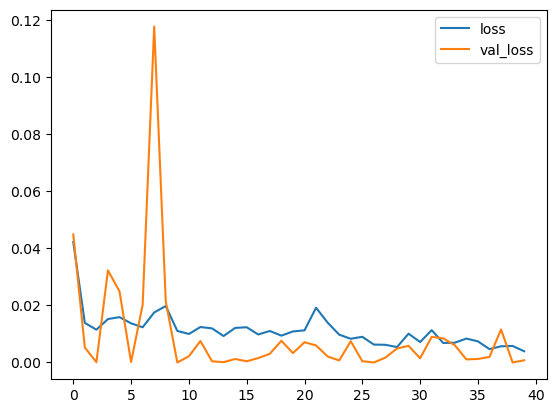

In [19]:
losses = pd.DataFrame(lstm_model.history.history)
losses.plot()

### Prediction on test data

Next we are going to make a prediction for 12 months (12 predictions). To do this we are going to do the following:
- create an empty list for each of our 12 predictions
- create the batch that our model will predict
- save the prediction to our list
- add the prediction to the end of the batch to use it in the next prediction

In [20]:
# create an empty list for each of our 12 predictions
pred_list = []

#create the batch that our model will predict: 
#selecting the last n_input data points from the scaled training data set to form the first batch of data to be 
#fed to the LSTM model.
#adjusting the batch of data to have the shape required by the LSTM model, which is (number of samples, time steps,
#number of features).
batch = train_scaled[-n_input:].reshape((1, n_input, n_features))

#save the prediction to our list:
#The for loop is iterating over each data point in the test data set. For each iteration, do the following:
for i in range(n_input): 
    
     # get prediction 1 time stamp ahead 
    pred_list.append(lstm_model.predict(batch)[0]) 
    
    # update batch to now include prediction and drop first value
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

1/1 [==============================] - 0s 155ms/step


#### Reverse the transformation

In [21]:
#downscaling the LSTM model predictions so that they are on the same scale as the original data
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])

In [22]:
#concatenate test and df_predict
df_test = pd.concat([test,df_predict], axis=1)

In [23]:
df_predict.size

12

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


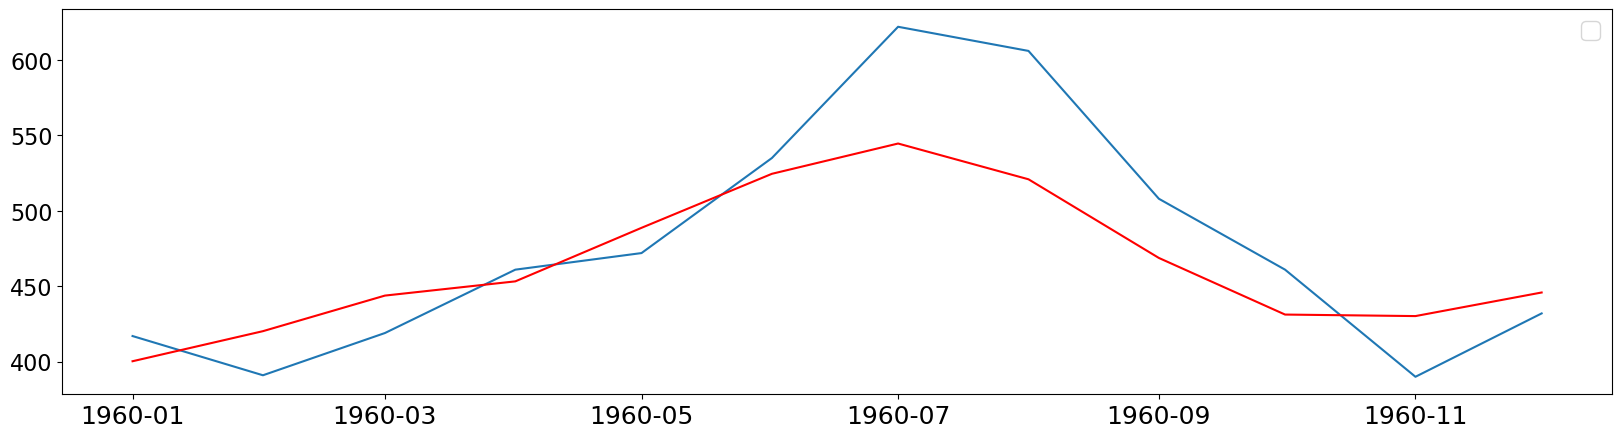

In [24]:
#Current passenger numbers and model prediction
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['AirPassengers'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [25]:
#calculating the root mean square error (RMSE)
lstm_rmse_error = rmse(df_test['AirPassengers'], df_test["Prediction"])

#calculating the mean square error (MSE) by squaring the RMSE.
lstm_mse_error = lstm_rmse_error**2

#calculating the average value of monthly beer production.
mean_value = df['AirPassengers'].mean()

#the MSE, and RMSE and the mean value are printed
print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 1638.6298544591286
RMSE Error: 40.47999326159935
Mean: 280.2986111111111


### Retrain and predict new data

In [26]:
#the entire data frame equals train
train = df

In [27]:
#scaler learns the parameters from the data frame. These parameters are used to transform the data.
#the data frame is scaled (e.g., standardized or normalized) using the parameters learned.
scaler.fit(train)
train = scaler.transform(train)

In [28]:
#creation of the Time Series Generator object.
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [29]:
#model fit
lstm_model.fit_generator(generator,epochs=90)

Epoch 1/90
22/22 [==============================] - 3s 149ms/step - loss: 0.0031
Epoch 2/90
22/22 [==============================] - 3s 120ms/step - loss: 0.0042
Epoch 3/90
22/22 [==============================] - 3s 142ms/step - loss: 0.0039
Epoch 4/90
22/22 [==============================] - 3s 129ms/step - loss: 0.0032
Epoch 5/90
22/22 [==============================] - 3s 126ms/step - loss: 0.0036
Epoch 6/90
22/22 [==============================] - 3s 128ms/step - loss: 0.0064
Epoch 7/90
22/22 [==============================] - 3s 123ms/step - loss: 0.0033
Epoch 8/90
22/22 [==============================] - 3s 129ms/step - loss: 0.0030
Epoch 9/90
22/22 [==============================] - 3s 131ms/step - loss: 0.0032
Epoch 10/90
22/22 [==============================] - 3s 123ms/step - loss: 0.0024
Epoch 11/90
22/22 [==============================] - 3s 123ms/step - loss: 0.0026
Epoch 12/90
22/22 [==============================] - 3s 125ms/step - loss: 0.0020
Epoch 13/90
22/22 [======

### extra sample forecasts (new data)

In [30]:
#create an empty list for each of our 12 prediction
pred_list = []

#create the batch that our model will predict: 
#adjusting the batch of data to have the shape required by the LSTM model, which is (number of samples, time steps,
#number of features).
batch = train[-n_input:].reshape((1, n_input, n_features))

#save the prediction to our list:
#The for loop is iterating over each data point in the test data set. For each iteration, do the following:
for i in range(n_input):   
    pred_list.append(lstm_model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

1/1 [==============================] - 0s 172ms/step


### Reverse the transformation

#### Generate a list of future dates and creates an empty DataFrame with those dates as indexes and the same columns as the original DataFrame.

In [31]:
#import DateOffset class from pandas.tseries.offsets module
from pandas.tseries.offsets import DateOffset

#Creating future dates:
#create a list called add_dates.
#Uses a list comprehension to generate future dates based on the last index date (df.index[-1]) plus a monthly offset
#(DateOffset(months=x)). The scroll range is 0 to 12 (13 months total).
add_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,13) ]

#Creating DataFrame of future dates:
#creates a DataFrame called future_dates.
#Use pd.DataFrame() to initialize an empty DataFrame with indexes based on the dates calculated in add_dates[1:] 
#(we skip the first date because it's already in the original set).
#The DataFrame column names are taken from the original DataFrame df (columns=df.columns).
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [32]:
#downscaling the LSTM model predictions so that they are on the same scale as the original data
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

#concatenating test with df_predict
df_proj = pd.concat([df,df_predict], axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


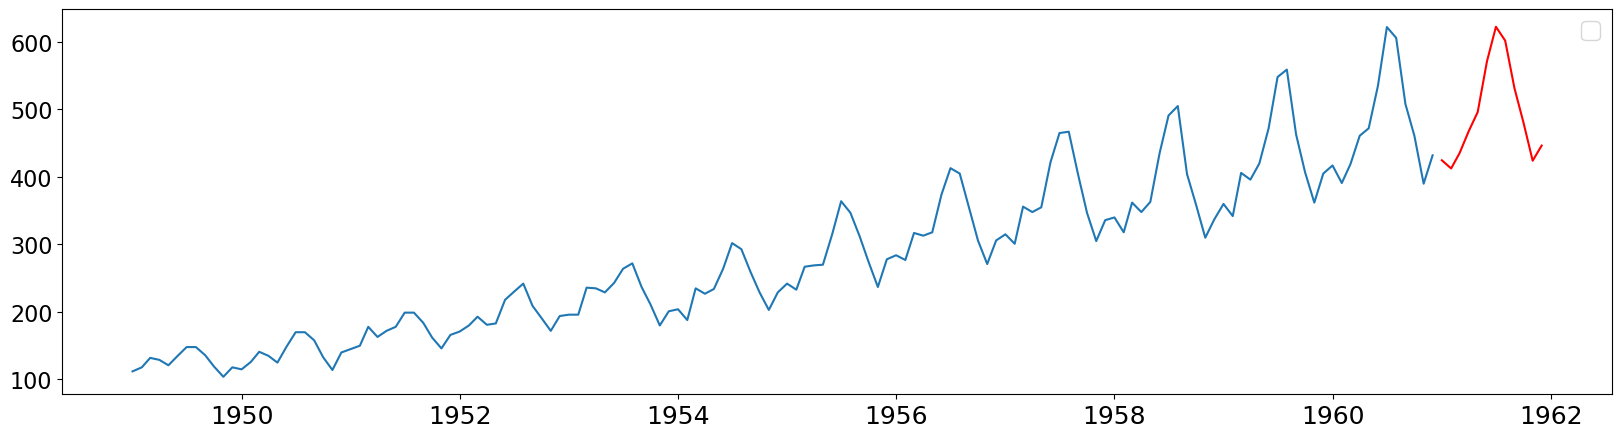

In [33]:
#Current passenger numbers and model prediction
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['AirPassengers'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()